## discussionのbaseline lgbmを参考

In [1]:
file_num = '012'

In [2]:
import json
import pickle
import re
from glob import glob
from tqdm import tqdm
from pdb import set_trace as trace
from xfeat import Pipeline, SelectCategorical, LabelEncoder
import seaborn as sns
import regex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import log_loss

In [3]:
def removeZenkakuSpace(df, cols):
    for col in cols:
        df[col] = df[col].str.replace('　', ' ')
    return df

def histEachFavs(df, col, height=3, aspect=4, title=''):
    for fav in sorted(df[FAV].unique()):
        sns.catplot(x=col,data=df.query(f"{FAV} == @fav"),kind='count',height=height, aspect=aspect)
        plt.title(f'{title} fav group:{fav}')
        
def getQueries(df, cols):
    assert type(cols) == str or type(cols) == list, 'cols is str or list'
    queries = []
    if type(cols) == str:
        queries = [f'{cols} == {flag}' for flag in sorted(df[cols].unique())]
    elif type(cols) == list:
        for col in cols:
            col_queries = [f'{col} == {flag}' for flag in sorted(df[col].unique())]
            if len(queries) == 0:
                queries = col_queries
            else:
                queries = [f"{q} & {col_queries[0]}" for q in queries] + [f'{q} & {col_queries[1]}' for q in queries]
            
    return queries

def columnUnique(df, col):
    return sorted(df[col].unique())

def histColumnsFavs(df, cols:list, height=3, aspect=6, title=''):
    queries = getQueries(df, cols)
    for query in queries:
        data = df.query(query)
        if len(data) == 0:
            continue
        sns.catplot(x=FAV,data=data,kind='count',height=height, aspect=aspect)
        plt.title(f'{title} {query}')
        
def histEachFavsByCategory(df, df_target, col):
    cats = sorted(df[col].unique())
    for cat in cats:
        fig, axes = plt.subplots(figsize=(30,10), ncols=3, nrows=2)
        for ax, fav in zip(axes.ravel(), favs):
            target_mask = (df[FAV] == fav) & (df[col] == cat)
            ax.hist(df_target.loc[target_mask], bins=100)
            ax.set_xlim(-1,df_target.max())
            ax.set_title(f'bgenre:{cat}, fav:{fav}, num={target_mask.sum()}')

In [4]:
def featureNumKeywords(df):
    num_keywords = np.vectorize(lambda x: len(x.split()))(df.keyword)
    return pd.DataFrame(data=num_keywords, columns=['num_keywords'])

def featureMaxSentenceLength(story):
    sentences_len = [len(sentence) for sentence in story.split('\n')]
    return max(sentences_len)
    
def featureNumIndent(story):
    return len(list(filter(lambda x: len(x) == 0 ,story.split('\n'))))
    
def featureStory(df):
    feature_df = pd.DataFrame()
    feature_df['num_sentence'] = df.story.str.count('\n')
    feature_df['max_sentence_len'] = np.vectorize(featureMaxSentenceLength)(df.story)
    feature_df['mean_sentence_len'] = (df.story.str.len() / (df.story.str.count('\n') +1)).astype('int')
    feature_df['num_indent'] = np.vectorize(featureNumIndent)(df.story)
    
    return feature_df
    
def concatDfs(dfs:list):
    concat_df = pd.DataFrame()
#     trace()
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        concat_df = pd.concat([concat_df, df], axis=1)
        
    return concat_df 

In [5]:
out_dir = '../output'
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
sub_df = pd.read_csv('../dataset/sample_submission.csv')
sub_columns = sub_df.drop('ncode', axis=1).columns
ID = 'ncode'
TARGET = 'fav_novel_cnt_bin'
favs = sorted(train_df[TARGET].unique())

# # train_df.userid = train_df.userid.astype('str')
# train_df.genre = train_df.genre.astype('str')
# test_df.userid = test_df.userid.astype('str')
# test_df.genre = test_df.genre.astype('str')
str_cols = ['title', 'story', 'keyword', 'writer']

In [6]:
train_df = removeZenkakuSpace(train_df, str_cols)
test_df = removeZenkakuSpace(test_df, str_cols)

In [7]:
all_df = pd.concat([train_df,test_df])
train_idx = len(train_df)

In [8]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(all_df)
all_df['writer'] = le_df['writer']

In [68]:
mask_latest = train_df.general_firstup.str.contains('202')

In [9]:
train_df.columns

Index(['ncode', 'general_firstup', 'title', 'story', 'keyword', 'userid',
       'writer', 'biggenre', 'genre', 'novel_type', 'end', 'isstop', 'isr15',
       'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni', 'pc_or_k',
       'fav_novel_cnt_bin'],
      dtype='object')

In [10]:
all_df.keyword = all_df.keyword.fillna('')

In [11]:
import datetime

dt_now = datetime.datetime.now()
# all_df['past_days'] = all_df['general_firstup'].apply(lambda x: (dt_now - datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')).days)

In [12]:
num_keyword_df = featureNumKeywords(all_df)

In [13]:
story_df = featureStory(all_df)

In [14]:
len(all_df)

48522

In [15]:
drop_cols = ['end', 'isstop', 'writer', 'ncode', 'general_firstup', 'title', 'story', 'keyword']

In [16]:
all_df = all_df.drop(drop_cols, axis=1)
all_df.columns

Index(['userid', 'biggenre', 'genre', 'novel_type', 'isr15', 'isbl', 'isgl',
       'iszankoku', 'istensei', 'istenni', 'pc_or_k', 'fav_novel_cnt_bin'],
      dtype='object')

In [17]:
cat_cols = ['userid', 'biggenre', 'genre', 'novel_type', 'isr15', 'isbl', 'isgl', 'iszankoku', 'istensei', 'istenni']

In [18]:
num_cols = ['past_days'] + list(num_keyword_df.columns) + list(story_df.columns)

In [19]:
feat_cols = cat_cols + num_cols

In [20]:
concat_df = concatDfs([all_df, num_keyword_df, story_df])
display(concat_df.shape)

(48522, 17)

In [21]:
concat_df

,userid,biggenre,genre,novel_type,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,fav_novel_cnt_bin,num_keywords,num_sentence,max_sentence_len,mean_sentence_len,num_indent
0,9904,4,402,1,0,0,0,0,0,0,0,1.0,5,4,199,49,2
1,6527,4,401,1,0,0,0,0,0,0,3,2.0,14,0,113,113,0
2,13882,4,403,1,0,0,0,0,0,0,0,3.0,6,4,38,25,1
3,13920,4,402,1,0,0,0,0,0,0,2,1.0,13,0,128,128,0
4,12136,4,401,1,0,0,0,0,0,0,1,1.0,12,0,179,179,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48517,2263100,99,9903,2,0,0,0,0,0,0,2,NaN,4,0,75,75,0
48518,2254651,3,305,2,0,0,0,0,0,0,2,NaN,10,4,43,22,2
48519,846989,3,302,2,0,0,0,0,0,0,2,NaN,2,0,51,51,0
48520,2259847,2,202,2,0,0,0,0,0,0,2,NaN,0,8,42,19,2


In [22]:
train = concat_df.iloc[:train_idx, :]
test = concat_df.iloc[train_idx:, :]

In [23]:
train.columns

Index(['userid', 'biggenre', 'genre', 'novel_type', 'isr15', 'isbl', 'isgl',
       'iszankoku', 'istensei', 'istenni', 'pc_or_k', 'fav_novel_cnt_bin',
       'num_keywords', 'num_sentence', 'max_sentence_len', 'mean_sentence_len',
       'num_indent'],
      dtype='object')

In [24]:
test = test.reset_index(drop=True).drop(TARGET,axis=1)

In [25]:
def fit(tr_x, tr_y, va_x, va_y, tr_w=None, va_w=None):
    """
    model training
  
    Parameters
    ----------
    tr_x: pd.DataFrame
    tr_y: pd.DataFrame
    va_x: pd.DataFrame
    va_y: pd.DataFrame

    Returns
    ----------
    model:
        - 学習済みモデル
    va_pred: 
        - 検証データの予測結果
    """ 
    params = {
        'objective': 'multiclass',
        'num_classes': 5,
        'metric': 'multi_logloss',
#         'num_leaves': 42,
#         'max_depth': 7,
#         "feature_fraction": 0.8,
#         'subsample_freq': 1,
#         "bagging_fraction": 0.95,
#         'min_data_in_leaf': 2,
        'learning_rate': 0.01,
        "boosting": "gbdt",
#         "lambda_l1": 0.1,
#         "lambda_l2": 10,
#         "verbosity": -1,
#         "random_state": 42,
        'seed':777,
        'n_jobs': -1,
        'verbose':-1,
        "num_boost_round": 1000,
        "early_stopping_rounds": 100
    }
    
    lgb_train = lgb.Dataset(tr_x, tr_y)
    lgb_eval = lgb.Dataset(va_x, va_y, reference=lgb_train)
    model = lgb.train(
        params,
        train_set=lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        verbose_eval=20
    )
    
    va_pred = model.predict(va_x)
    
    return model, va_pred

In [26]:
def scoreing(y_true, y_prob):
    return log_loss(y_true, y_prob)

In [27]:
train.columns

Index(['userid', 'biggenre', 'genre', 'novel_type', 'isr15', 'isbl', 'isgl',
       'iszankoku', 'istensei', 'istenni', 'pc_or_k', 'fav_novel_cnt_bin',
       'num_keywords', 'num_sentence', 'max_sentence_len', 'mean_sentence_len',
       'num_indent'],
      dtype='object')

In [28]:
X = train.drop(TARGET, axis=1)
y = train[TARGET]

In [29]:
models = []
df_pred = pd.DataFrame(index=X.index, columns=sub_columns)
kf = StratifiedKFold(n_splits=5)
# kf = KFold(n_splits=10)
for idx, (train_idx, valid_idx) in enumerate(kf.split(X, y), 1):
    print(f'----CV:{idx}----')
    X_train, y_train = X.loc[train_idx], y.loc[train_idx]
    X_valid, y_valid = X.loc[valid_idx], y.loc[valid_idx]
    
    model, va_pred = fit(X_train, y_train, X_valid, y_valid)
    models.append(model)
    
    df_pred.loc[valid_idx] = va_pred

----CV:1----
Training until validation scores don't improve for 100 rounds


/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/wsato/work/venv/lib/python3.8/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	training's multi_logloss: 1.08983	valid_1's multi_logloss: 1.12897
[40]	training's multi_logloss: 1.03238	valid_1's multi_logloss: 1.09365
[60]	training's multi_logloss: 0.992472	valid_1's multi_logloss: 1.06932
[80]	training's multi_logloss: 0.962988	valid_1's multi_logloss: 1.05171
[100]	training's multi_logloss: 0.940116	valid_1's multi_logloss: 1.03814
[120]	training's multi_logloss: 0.921315	valid_1's multi_logloss: 1.02746
[140]	training's multi_logloss: 0.906222	valid_1's multi_logloss: 1.01898
[160]	training's multi_logloss: 0.893561	valid_1's multi_logloss: 1.01309
[180]	training's multi_logloss: 0.88294	valid_1's multi_logloss: 1.0091
[200]	training's multi_logloss: 0.873985	valid_1's multi_logloss: 1.00512
[220]	training's multi_logloss: 0.865649	valid_1's multi_logloss: 1.00226
[240]	training's multi_logloss: 0.8582	valid_1's multi_logloss: 1.00012
[260]	training's multi_logloss: 0.851589	valid_1's multi_logloss: 0.999063
[280]	training's multi_logloss: 0.845443	valid_

In [30]:
scoreing(train[TARGET], df_pred)

0.9539221856698947

In [31]:
def predict(models, x):
    result = pd.DataFrame(0, index=x.index, columns=sub_columns)
    for model in models:
        pred_prob = model.predict(x, num_iteration=model.best_iteration)
        df_pred = pd.DataFrame(pred_prob, index=x.index, columns=sub_columns)
        result += df_pred
    result = result/5
    return result

In [33]:
result = predict(models, test)

In [34]:
sub_df.iloc[:, 1:] = result
# sub_dfTARGET

In [35]:
sub_df.to_csv(f'../output/{file_num}_test_submission.csv', header=True, index=False)

(array([5638.,    0., 2220.,    0.,    0.,  249.,    0.,  360.,    0.,
          55.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

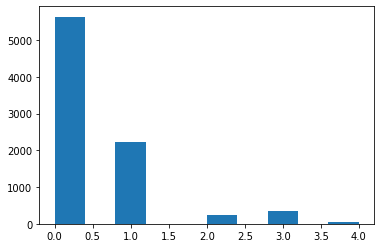

In [46]:
plt.hist(np.argmax(np.array(sub_df.drop('ncode',axis=1)),axis=1))

In [37]:
ans = np.argmax(np.array(df_pred),axis=1)

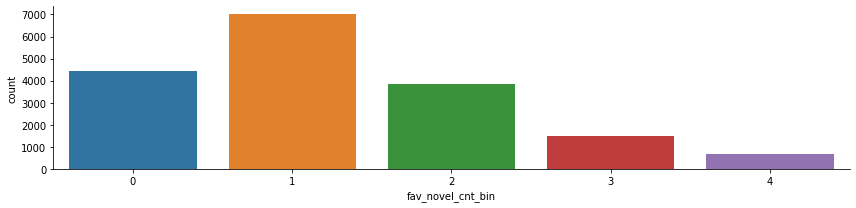

In [74]:
sns.catplot(x=TARGET, data=train_df.query(f'{TARGET} != @ans'), kind='count', height=3,aspect=4)

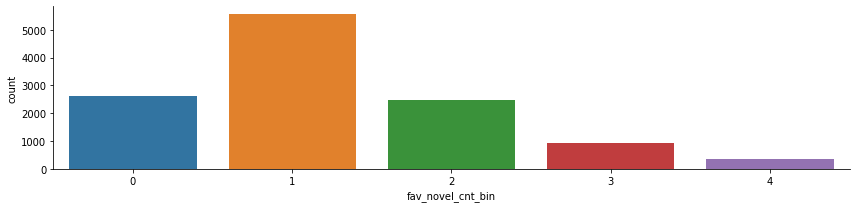

In [73]:
sns.catplot(x=TARGET, data=train_df.query(f'{TARGET} != @ans').loc[mask_latest], kind='count', height=3,aspect=4)

In [ ]:
dnum = 200
nrow = int(len(ans)/dnum)
fig, axes = plt.subplots(figsize=(20,3*nrow),ncols=1,nrows=nrow)
for idx, ax in enumerate(axes.ravel()):
    ax.scatter(np.arange(dnum),ans[dnum*idx:dnum*(idx+1)])
    ax.scatter(np.arange(dnum),train_df[TARGET][dnum*idx:dnum*(idx+1)])
    

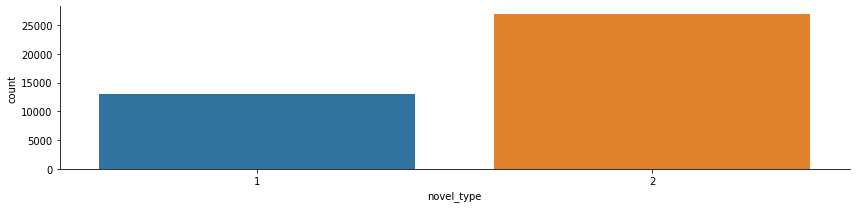

In [40]:

sns.catplot(x='novel_type', data=train_df, kind='count', height=3,aspect=4)

In [ ]:
sns.catplot(x='biggenre', data=train_df.query(f'{TARGET} != @ans'), kind='count', height=3,aspect=4)
sns.catplot(x='general_firstup', data=train_df, kind='count', height=3,aspect=4)

(array([1.6958e+04, 2.9720e+03, 1.1380e+03, 1.7130e+03, 2.4300e+02,
        1.2400e+02, 6.2000e+01, 3.4000e+01, 2.2000e+01, 1.1000e+01]),
 array([ 106. ,  630.7, 1155.4, 1680.1, 2204.8, 2729.5, 3254.2, 3778.9,
        4303.6, 4828.3, 5353. ]),
 <BarContainer object of 10 artists>)

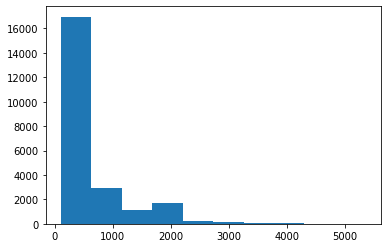

In [58]:
plt.hist(train.query(f'{TARGET} == @ans')['past_days'])

(array([27947.,  5141.,  2190.,  3447.,   629.,   333.,   181.,    70.,
           34.,    28.]),
 array([ 106. ,  630.7, 1155.4, 1680.1, 2204.8, 2729.5, 3254.2, 3778.9,
        4303.6, 4828.3, 5353. ]),
 <BarContainer object of 10 artists>)

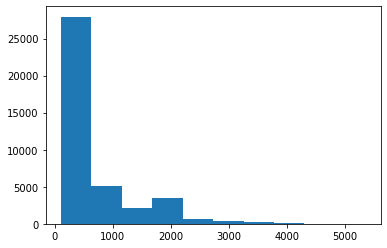

In [62]:
plt.hist(train.past_days.values)

In [63]:
train_df.general_firstup

0        2007-04-01 16:40:57
1        2007-04-22 15:40:30
2        2007-08-22 18:25:54
3        2007-09-06 21:33:37
4        2007-09-17 01:02:33
                ...         
39995    2021-08-12 07:00:00
39996    2021-08-12 07:36:14
39997    2021-08-12 07:44:36
39998    2021-08-12 08:00:00
39999    2021-08-12 08:00:00
Name: general_firstup, Length: 40000, dtype: object

In [73]:

train_df['up_month'] = np.vectorize(lambda x: '-'.join(x.split('-')[0:2]))(train_df.general_firstup)
train_df['up_year'] = np.vectorize(lambda x: '-'.join(x.split('-')[0:1]))(train_df.general_firstup)

In [72]:
train_df.up_month.value_counts()

2021-07    6521
2021-06    4365
2021-05    3162
2021-08    2303
2021-04    2028
           ... 
2008-12       1
2010-01       1
2009-12       1
2010-07       1
2009-02       1
Name: up_month, Length: 166, dtype: int64

In [61]:
train.past_days

0        5353
1        5332
2        5209
3        5194
4        5184
         ... 
39995     106
39996     106
39997     106
39998     106
39999     106
Name: past_days, Length: 40000, dtype: int64

In [36]:
sub_df.iloc[:, 1:] = result
sub_dfTARGET

,ncode,proba_0,proba_1,proba_2,proba_3,proba_4
0,N4541HD,0.907879,0.900706,0.180805,0.009291,0.001320
1,N4397HD,0.178771,0.503034,0.505194,0.683453,0.129548
2,N4544HD,1.665456,0.325255,0.006549,0.001994,0.000746
3,N4545HD,0.629683,0.876919,0.191672,0.248262,0.053464
4,N4546HD,1.221297,0.666630,0.104271,0.006556,0.001246
...,...,...,...,...,...,...
8517,N5983HF,1.438923,0.534632,0.021114,0.004450,0.000880
8518,N5990HF,1.316185,0.657569,0.016604,0.008219,0.001423
8519,N5993HF,1.476334,0.470087,0.045836,0.006332,0.001411
8520,N5996HF,1.676974,0.306446,0.013811,0.001958,0.000811


In [37]:
sub_df.to_csv(f'../output/test_submission_{file_num}.csv', header=True, index=False)

In [24]:
accuracy = sum(val_y == val_pred_max) / len(val_y)
print(accuracy)

0.6446


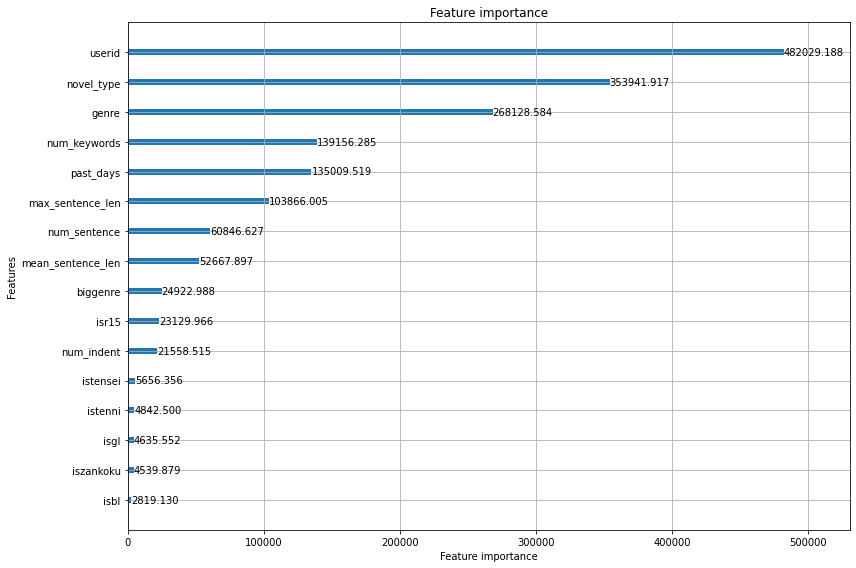

In [26]:
lgbm.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

(array([[2498.,    0., 1741.,    0.,    0.,  491.,    0.,  223.,    0.,
           47.],
        [3122.,    0., 1379.,    0.,    0.,  365.,    0.,  118.,    0.,
           16.]]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 BarContainer objects>)

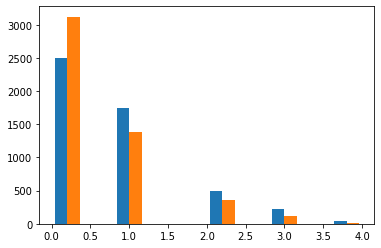

In [23]:
plt.hist([val_y, val_pred_max])

In [27]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)
sub_df.iloc[:, 1:] = test_pred
sub_df.to_csv(f'../output/test_submission_{file_num}.csv', index=False)